# RAPPOR – Server-side

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Settings

Some setting for the main analysis:

In [2]:
use_superset = False
superset_size = 800

use_lasso = False

One of five distributions can be chosen:

In [3]:
distributions = ["gauss", "zipf1", "zipf1.5", "exp", "unif"]
distribution = distributions[3]

Disabling scientific notation makes it a bit easier to compare numeric values with the ones logged in the R part:

In [4]:
np.set_printoptions(suppress=True)

## Reading the data files

In production, the content of these files is coming from the clients. For testing, we just use files that are generated by Google's simulations.

In [5]:
data_folder = "../data/"

There are several different simulations available. They all use the tuned parameters and 1.000.000 users. Ordered by difficulty:
- *small*: 100 unique values that are reported
- *small-200*: 200 unique values that are reported
- *small-unbalanced-200*: Additionally, sers are assigned to cohorts uniformly randomly, just like we will do it on the client
- *small-unbalanced-400*: 400 unique values that are reported, and unbalanced cohorts

In [6]:
dataset_collections = ["small", "small-200", "small-unbalanced-200", "small-unbalanced-400"]
dataset_collection = dataset_collections[3]

In [7]:
def get_paths(data_folder, distribution):
    base = "%s/r-%s-%s-sim_final/" % (data_folder, distribution, dataset_collection)

    params_path = base + "case_params.csv"
    counts_path = base + "1/case_counts.csv"
    map_path = base + "case_map.csv"
    candidates_path = base + "case_unique_values.txt" #"case_candidates.txt"
    true_values_path = base + "1/case_true_values.csv"
    
    return params_path, counts_path, map_path, candidates_path, true_values_path

In [8]:
PARAMS_PATH, COUNTS_PATH, MAP_PATH, CANDIDATES_PATH, TRUE_VALUES_PATH = get_paths(data_folder, distribution)

### params

In [9]:
def load_params(path):
    k, h, m, p, q, f = pd.read_csv(path).iloc[0]
    
    k = int(k)
    h = int(h)
    m = int(m)
    
    return k, h, m, p, q, f

In [10]:
k, h, m, p, q, f = load_params(PARAMS_PATH)

In [11]:
print "- The Bloom filter has k=%d bits and uses h=%d hash functions" % (k, h)
print "- There are m=%d cohorts" % m
print "- There is a f=%.2f probability of randomly changing a bit for the PRR" % f
print "- There is a p=%.2f (q=%.2f) probability of setting a bit in the IRR to 1 if that bit was 0 in the PRR" % (p, q)

- The Bloom filter has k=128 bits and uses h=2 hash functions
- There are m=100 cohorts
- There is a f=0.00 probability of randomly changing a bit for the PRR
- There is a p=0.35 (q=0.65) probability of setting a bit in the IRR to 1 if that bit was 0 in the PRR


### counts

Each row contains information about one cohort. The very first value in a row specifies the total number of reports in that cohort. The other values specify how often the respective bit was set in the sent Bloom Filter. Because some bits were randomly changed, the first value can be smaller or greater than the sum of the other values in that row.

Cohorts without any reports are directly removed.

In the real server implementation, we will need a little bit of additional logic for calculating these sums. Here, we just use what Google's implementation already provides.

In [12]:
def load_counts(path):
    counts = DataFrame.from_csv(path, header=None, index_col=None)
    counts = counts[counts[0] != 0]
    return counts

In [13]:
counts = load_counts(COUNTS_PATH)
counts.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,10139,3586,3529,3618,3655,3582,3551,3513,3645,3666,...,3613,3496,3576,3585,3597,3619,3641,3509,3599,3725
1,10061,3471,3538,3529,3445,3501,3600,3608,3601,3523,...,3685,3580,3550,3539,3586,3553,3539,3548,3589,3503
2,9844,3483,3463,3428,3502,3491,3561,3522,3495,3449,...,3559,3387,3472,3543,3453,3418,3550,3454,3463,3503
3,10021,3478,3618,3453,3552,3603,3604,3512,3424,3500,...,3567,3491,3610,3629,3652,3545,3480,3524,3521,3619
4,9964,3566,3480,3494,3499,3576,3567,3487,3509,3615,...,3531,3602,3431,3548,3516,3572,3504,3511,3469,3442


### Currently not used anywhere – map (hash values)

One row for every candidate string. The leftmost value in a row (Pandas' index) shows the respective string, the other values (number of cohorts * number of hash functions) show the hashed values of that string.

In [14]:
def load_map(path):
     return DataFrame.from_csv(path, header=None)

In [15]:
maps = load_map(MAP_PATH)
maps.head()

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,,,,,,,,,,,,,,,,,,,,,
v1,54,128,178,131,260,261,423,427,524,513,...,12216,12206,12301,12385,12442,12494,12647,12653,12797,12718
v2,23,104,240,215,301,370,508,420,540,542,...,12244,12271,12343,12404,12427,12491,12617,12557,12676,12736
v3,42,81,142,185,354,304,428,412,599,559,...,12271,12186,12328,12401,12494,12470,12597,12606,12719,12734
v4,30,5,184,182,362,263,406,450,540,519,...,12244,12271,12384,12350,12525,12435,12596,12662,12784,12715
v5,73,3,209,247,280,355,472,481,631,615,...,12226,12254,12397,12406,12422,12461,12596,12552,12735,12675


### candidates

Here, the candidates are simply the values that were also used by the client-side code. Generally, we would like to use a superset of these values, e.g. the most popular websites.

In [16]:
def get_candidates():
    with open(CANDIDATES_PATH) as f:
        lines = f.readlines()
        return [candidate.strip() for candidate in lines]

In [17]:
candidates = get_candidates()

Just for testing, we can try a superset:

In [18]:
if use_superset:
    candidates = ["v%d" % i for i in range(1, superset_size + 1)]

In [19]:
candidates[:10]

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10']

In [20]:
M = len(candidates)

Later on, we might want to filter candidates. If we do this, we still need to know how which candidates originally existed, so we save this information into variables:

In [21]:
candidates_total = candidates
M_total = M

### Preparing counts

First of all, we do some basic preprocessing to be able to use the same variables that are also being used by the RAPPOR paper. This makes it a bit easier to implement the math formulas given in the paper.

$N$ is a vector containing the number of reports from the individual cohorts. $c$ is a matrix
where $c_{ij}$ tells us how often bit $j$ was set in cohort $i$.

In [22]:
def destructure_counts(counts):
    N = counts[0].as_matrix()
    c = counts.drop([0], axis=1).as_matrix().T
    return N, c

In [23]:
N, c = destructure_counts(counts)

In the Google simulations, $N$ is a constant vector, i.e. each component has the same value. For our experiment, we assign users uniformly randomly to cohorts.

This means cohorts are generally not perfectly balanced, but by the law of large numbers the cohort distribution should converge to a uniform distribution.

**The next two visualizations are only interesting for datasets with unbalanced cohorts.**

<Container object of 100 artists>

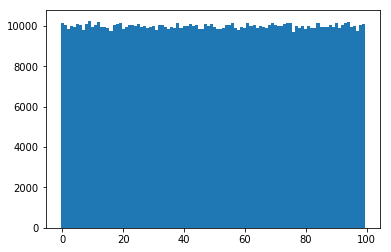

In [24]:
plt.bar(range(len(N)), N, width=1., align='center')

<Container object of 100 artists>

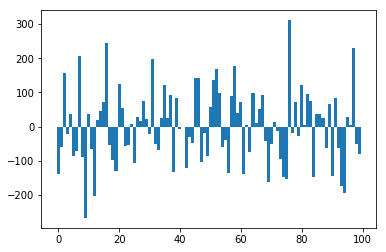

In [25]:
plt.bar(range(len(N)), N.mean() - N, width=1., align='center')

## Preparing the data to separate signal and noise

The high-level task of the server-side is to find out which candidate strings were really used by the clients. We will use statistical techniques for doing this, namely linear regression to find out which candidate strings probably influenced the final result.

Another way to think about this: In Machine Learning and statistics we are often concerned with separating signal from noise. Here, the signal is given by the hashed values of candidate strings. The noise is added on purpose by clients in order to maintain privacy. On the server-side, we then try to use statistical techniques to remove the noise from the aggregated data.

### Target values $y$: Estimating true counts of the original Bloom filter

The target values $y$ will contain estimates of how often the individual bits were really set in the original bloom filter.

$$
t_{ij} = \frac{c_{ij} - (p + 0.5fq - 0.5fp) N_j}{(1 - f) (q - p)}
$$

$Y$ is then simply a long vector that contains the rows of $t$ flattened. `estimate_bloom_counts` calculates $Y$ in a vectorized way.

**TODO**: Explain why this formula holds

(Preliminary answer: We remove the expected number of added 1s; we ignore the expected number of removed 1s because it's low and hard to estimate; the division seems to be based on a conditional probability, i.e. we compute the probability that a bit is 1 because of noise conditioned given the probability that it's 1 at all)

In [26]:
def estimate_bloom_count(c, N):
    Y = c - ((p + 0.5 * f * q - 0.5 * f * p) * N)
    Y /= ((1 - f) * (q - p))
    return Y

In [27]:
Y = estimate_bloom_count(c, N)

In [28]:
print Y.shape
assert(Y.shape == (k, m))

(128, 100)


This is not mentioned in the paper, but actually $Y$ is then also divided by $N$ to get frequencies instead of counts. We also reshape the matrix to one long vector, and call this $y$.

In [29]:
def get_target_values(c, N):
    Y = estimate_bloom_count(c, N)
    return (Y / N).T.reshape(k * m)

In [30]:
y = get_target_values(c, N)

### Design matrix $X$:  Encoding the hashed values of candidates

$X$ has the shape $km \times M$ where
- $k$ is the number of bits in the Bloom filter
- $m$ is the number of cohorts
- $M$ is the number of candidate strings

Each candidate string corresponds to one feature. Each feature has $h * m$ values set to $1$, all others are $0$. This makes $X$ a sparse matrix.

Each data point corresponds to one bit in a cohort. A cell in that row is set to $1$ if that bit would be set by using the respective hashed candidate string.

---

To get the bits set in a Bloom filter, we import a function from Google's repo. This is important because we need to make sure to use the same hash function in client and server.

In [31]:
from client.rappor import get_bloom_bits

This function gives us the bits that are set when the candidate string is hashed:

In [32]:
get_bloom_bits("test", 4, h, k)

[19, 108]

Next, we can finally create $X$ by creating the matrices of the individual cohorts, and then stacking them vertically.

In [33]:
def get_features(candidates):
    matrix = []

    for cohort in range(m):
        rows = []

        for candidate in candidates:
            bits = np.zeros(k)
            bits_set = get_bloom_bits(candidate, cohort, h, k)
            bits[bits_set] = 1
            rows.append(bits)

        for row in np.array(rows).T:
            matrix.append(row)

    X = np.array(matrix)
    
    return X

In [34]:
X = get_features(candidates)

In [35]:
print X.shape
assert(X.shape == (k * m, M))

(12800, 400)


To give some intuition on what we're doing here: The design matrix $X$ contains information about what bits would be set by which candidates. By using the estimated counts of the individual bits, we then try to infer which candidate strings really appeared.

**TODO**: Why do we use the estimated results, instead of the observed counts? 

(Preliminary answer: Probably because this already removes some noise (e.g. sets some target values to 0), so it's easier to fit afterwards)

## Optional – Lasso: Eliminating some candidates

In the RAPPOR paper, Google says they fit a Lasso model and only continue working with candidate strings that have non-zero coefficients. This acts as a preliminary filter to make the next model simpler.

The intuition behind this is that Lasso forces a lot of coefficients to be $0$ and only the coefficients that are very relevant get a larger coefficient. Here, we first want to filter for a good set of candidates, and then estimate counts for them. 

It might seem counterintuitive that we use two linear regressions for this, instead of just one Lasso regression. As far as I can see, there are two reasons for this:

- The first preliminary filtering uses the pure data $X, y$ without any preprocessing. This makes it easier to interpret the result. Before the second linear regression we perform a bunch of preprocessing and fit a model on $A, b$, so it's better to do this in a separate pure linear regression
- By performing the two regressions after each other, the estimates of the second regression are much better. If we only use one Lasso regression, we get rid of a lot of false positives, but the estimates for these potential false positives are just given to other candidates because Lasso allows some coefficients to be very large. Because of this, we end up overestimating the counts for nearly all found candidates. By doing a second pure linear regression, we can circumvent this problem

**TODO**: Verify if these reasons are accurate

To see if this explanation really makes sense, some analyses with only Lasso regression are performed at the bottom of this notebook.

In [36]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

In [37]:
def filter_candidates(X, y, candidates, alpha=0.0001):
    clf = Lasso(alpha=alpha)
    clf.fit(X, y)
    
    good_candidates = np.where(clf.coef_ > 0)[0]
    
    X = X[:, good_candidates]
    candidates = [candidates[i] for i in good_candidates]
    M = len(candidates)
    
    return X, candidates, M, good_candidates

However, actually, Google only performs this Lasso regression if the number of candidates $M$ is larger than $0.8 * m * k$, as this means the system is close to being underdetermined.

**TODO**: Understand why this exact condition exists

In [38]:
cut_off = 0.8 * m * k
perform_lasso = M > cut_off

print M, cut_off, "| Lasso should be performed:", perform_lasso

400 10240.0 | Lasso should be performed: False


It's not very clear if this is a good condition, so for now we're manually deciding whether to use it or not:

In [39]:
if use_lasso:
    X, candidates, M, good_candidates = filter_candidates(X, y, candidates)

Generally, one disadvantage of this filtering is that we have to find an appropriate hyperparameter $\alpha$ for weighting the regularization part of Lasso.

A second hyperparameter that (probably) needs to be set is whether Lasso should be used at all.

## Calculating standard deviations

Because the estimated $y$ values are just expected values, it's useful to also take spread into account. We do this by calculating the standard deviations of our estimates.

**TODO**: Understand how to derive this formula

The formulas for this are not given in the paper, so the code below is directly adapted from the R code:

In [40]:
def _std_row(row, p01, p11, p2):
    N = row[0]
    v = row[1:]
    
    p_hats = (v - p01 * N) / (N * p2) # expectation of a true 1
    p_hats = np.maximum(0, np.minimum(1, p_hats))
    
    r = p_hats * p11 + (1 - p_hats) * p01
        
    return N * r * (1 - r) / p2**2

def calculate_variances(counts):
    p01 = p * (1 - f / 2) + q * f / 2
    p11 = q * (1 - f / 2) + p * f / 2
    p2 = p11 - p01
    
    N = counts[0].as_matrix()
    
    return (np.sqrt(counts.apply(lambda row: _std_row(row, p01, p11, p2), axis=1).as_matrix().T) / N).T

In [41]:
stds = calculate_variances(counts).reshape((k * m))

Later, we will use the standard deviations to resample the estimates.

## Maybe optional – Normalizing the data matrix and target values

I'm not entirely sure why this is needed, and it's not mentioned in the paper, but Google also normalizes $X$ and $y$ to new variables $A, b$.

**TODO**: Understand why exactly this is needed. It seems like scaling normalization, but the $\min$ term makes it a bit odd.

In [42]:
def calculate_normalization(stds):
    w = 1 / stds
    w_median = np.median(w[np.isfinite(w)])

    if not np.isfinite(w_median):
        w_median = 1

    w = np.minimum(w, 2 * w_median)
    w = w / w.mean()

    return w

In [43]:
def normalize(X, y, stds):
    w = calculate_normalization(stds)
    
    # Multiplying to a digonal matrix is equivalent to multiplying each
    # row of X with the corresponding cell on the diagonal
    diag = np.diag(w)
    A = diag.dot(X)
    b = diag.dot(y)
    
    return A, b

In [44]:
A, b = normalize(X, y, stds)

## Second Linear Regression

In the paper, Google says they perform a "regular least-squares regression using the selected variables" but this is not true.
The input variables are changed a bit, as we saw before. Additionally, the linear regression [involves additional constraints](https://github.com/google/rappor/blob/master/analysis/R/alternative.R#L22-26) that are not described in the paper.

The following constraints must hold for valid coefficients $x$:

#### $x$ must be nonnegative

The coefficients correspond to frequencies of how often the respective candidate was approximately reported by a client, so it makes sense for them to be nonnegative.

A nonnegativity constraint is supported by many least squares implementations.

####  $x$ sums up to a value smaller or equal to $1$

$y$ contains frequencies, not counts. So it makes sense that $x$ also gives us frequencies.

#### Standard deviation

If we use $x$ to estimate the bit counts in the Bloom filter, this estimate may not exceed the $y$ estimates by more than 3 standard deviations. This is just a constraint to make sure that we don't end up with a solution $x$ that works super well for some estimates but not at all for others.

This third constraint however makes things a bit more difficult. In general, sklearn and SciPy cannot deal with it automatically. Because of this, we have to fallback to a more low-level optimizer here that allows us to encode arbitrary constraints.

In [45]:
from scipy.optimize import minimize, nnls
from numpy.linalg import norm

For the third constraint, we introduce a new variable $yy$ that gives a limit for how much predicted values may differ.

In [46]:
yy = np.minimum(1, np.maximum(y + 3 * stds, 0.01))

Because of the generality of our optimizer, it's important to choose a good first guess $x_0$. We generate this guess by quickly training a model using the first two constraints, but without the third. This turns out to be the critical change that allows us to get the same results as the optimization library used in R by Google.

In [47]:
x0, _ = nnls(A, b)

The cost function is simply least squares, i.e. we want to minimize $||Ax - b||_2^2$.

In [48]:
def cost(x):
    return norm(A.dot(x) - b, ord=2)**2

Finally, we encode the third constraint, and run the minimizer.

In [49]:
standard_deviation_constraint = {
    "type": "ineq",
    "fun": lambda x: max(X.dot(x) - yy)
}

In [50]:
x = minimize(cost,
         x0=x0,
         method="SLSQP",
         constraints=standard_deviation_constraint,
         bounds=zip(np.zeros(M), np.ones(M))
        ).x

x

array([ 0.01263132,  0.0115197 ,  0.0135035 ,  0.01119926,  0.01101638,
        0.0122229 ,  0.01151017,  0.01055394,  0.00892169,  0.00888274,
        0.01079017,  0.00853863,  0.01157853,  0.00820821,  0.01261386,
        0.01062734,  0.01291417,  0.01092515,  0.00920178,  0.01193804,
        0.0098857 ,  0.00923034,  0.00825635,  0.01044891,  0.00834649,
        0.00942326,  0.00777068,  0.00893365,  0.0075246 ,  0.00958396,
        0.00881832,  0.00802529,  0.00933292,  0.00755087,  0.00814861,
        0.00864242,  0.00904078,  0.00680687,  0.00732511,  0.00685558,
        0.00600868,  0.00765151,  0.00861554,  0.00738655,  0.00866041,
        0.00825158,  0.00768709,  0.00787514,  0.0064502 ,  0.00841272,
        0.00615917,  0.00535157,  0.00637693,  0.00433773,  0.00685581,
        0.00535522,  0.00579898,  0.00481263,  0.00606353,  0.00461647,
        0.0055677 ,  0.00716995,  0.0066711 ,  0.00609519,  0.00532402,
        0.00622315,  0.00473178,  0.00470853,  0.00402044,  0.00

It depends a bit on the dataset, but for the first iteration we usually get the exact same results as Google's RAPPOR here.

Finally, we can put it all together:

In [51]:
def fit(X, y, stds):
    A, b = normalize(X, y, stds)
    yy = np.minimum(1, np.maximum(y + 3 * stds, 0.01))
    
    standard_deviation_constraint = {
        "type": "ineq",
        "fun": lambda x, X, yy: max(X.dot(x) - yy),
        "args": (X, yy)
    }
        
    x0, _ = nnls(A, b)
    x = minimize(lambda x: norm(A.dot(x) - b, ord=2)**2,
         x0=x0,
         method="SLSQP", # TNC or SLSQP
         constraints=standard_deviation_constraint,
         bounds=zip(np.zeros(len(x0)), np.ones(len(x0))),
         options={ "maxiter": 1000 }
        ).x
    
    return x

### TNC

TNC finds the exact same optimum as R. However, this only works here because the best solution is independent of the third constraint in this case. Of course, generally that's not true, so we can't use TNC without ditching the third constraint.

In [52]:
tnc_options = {
    "maxiter": 100000000,
    "disp": True
}


In [53]:
minimize(cost,
         x0=x0,
         method="TNC",
         bounds=zip(np.zeros(M), np.ones(M)),
         options=tnc_options
        ).x

array([ 0.01263132,  0.0115197 ,  0.0135035 ,  0.01119926,  0.01101638,
        0.0122229 ,  0.01151017,  0.01055394,  0.00892169,  0.00888274,
        0.01079017,  0.00853863,  0.01157853,  0.00820821,  0.01261386,
        0.01062734,  0.01291417,  0.01092515,  0.00920178,  0.01193804,
        0.0098857 ,  0.00923034,  0.00825635,  0.01044891,  0.00834649,
        0.00942326,  0.00777068,  0.00893365,  0.0075246 ,  0.00958396,
        0.00881832,  0.00802529,  0.00933292,  0.00755087,  0.00814861,
        0.00864242,  0.00904078,  0.00680687,  0.00732511,  0.00685558,
        0.00600868,  0.00765151,  0.00861554,  0.00738655,  0.00866041,
        0.00825158,  0.00768709,  0.00787514,  0.0064502 ,  0.00841272,
        0.00615917,  0.00535157,  0.00637693,  0.00433773,  0.00685581,
        0.00535522,  0.00579898,  0.00481263,  0.00606353,  0.00461647,
        0.0055677 ,  0.00716995,  0.0066711 ,  0.00609519,  0.00532402,
        0.00622315,  0.00473178,  0.00470853,  0.00402044,  0.00

### Ignoring the third constraint

Another alternative is consciously ignoring the third constraint while choosing a minimizer that reaches a good solution. So far, this seems to be the best approach here: 

In [54]:
def fit(X, y, stds):
    A, b = normalize(X, y, stds)
    x0, _ = nnls(A, b)
    #x0, _ = nnls(X, y)
    return x0

In [55]:
fit(X, y, stds)

array([ 0.01263132,  0.0115197 ,  0.0135035 ,  0.01119926,  0.01101638,
        0.0122229 ,  0.01151017,  0.01055394,  0.00892169,  0.00888274,
        0.01079017,  0.00853863,  0.01157853,  0.00820821,  0.01261386,
        0.01062734,  0.01291417,  0.01092515,  0.00920178,  0.01193804,
        0.0098857 ,  0.00923034,  0.00825635,  0.01044891,  0.00834649,
        0.00942326,  0.00777068,  0.00893365,  0.0075246 ,  0.00958396,
        0.00881832,  0.00802529,  0.00933292,  0.00755087,  0.00814861,
        0.00864242,  0.00904078,  0.00680687,  0.00732511,  0.00685558,
        0.00600868,  0.00765151,  0.00861554,  0.00738655,  0.00866041,
        0.00825158,  0.00768709,  0.00787514,  0.0064502 ,  0.00841272,
        0.00615917,  0.00535157,  0.00637693,  0.00433773,  0.00685581,
        0.00535522,  0.00579898,  0.00481263,  0.00606353,  0.00461647,
        0.0055677 ,  0.00716995,  0.0066711 ,  0.00609519,  0.00532402,
        0.00622315,  0.00473178,  0.00470853,  0.00402044,  0.00

## Resampling

A popular way to get more data is resampling. Here, we use the standard deviations to do this.

In [56]:
from numpy.random import normal, seed

In [57]:
def resample(y, stds):
    y_old = y
    
    deviation = np.array([normal(0, std) for std in stds])
    y = y + deviation
        
    stds = stds * np.sqrt(2)
        
    return y, stds

In [58]:
from time import time

In [59]:
def find_coefs(X, y, stds, verbose=False):
    coefs = []

    for i in range(5):
        t = time()

        if i > 0:
            y_resampled, stds_resampled = resample(y, stds)
        else:
            y_resampled, stds_resampled = y, stds

        coefs.append(fit(X, y_resampled, stds_resampled))

        if verbose:
            print "Iteration %d took %.3f seconds" % (i + 1, time() - t)
        
    return coefs

In [60]:
coefs = find_coefs(X, y, stds, verbose=True)
coefs

Iteration 1 took 4.604 seconds
Iteration 2 took 4.566 seconds
Iteration 3 took 4.639 seconds
Iteration 4 took 4.655 seconds
Iteration 5 took 4.529 seconds


[array([ 0.01263132,  0.0115197 ,  0.0135035 ,  0.01119926,  0.01101638,
         0.0122229 ,  0.01151017,  0.01055394,  0.00892169,  0.00888274,
         0.01079017,  0.00853863,  0.01157853,  0.00820821,  0.01261386,
         0.01062734,  0.01291417,  0.01092515,  0.00920178,  0.01193804,
         0.0098857 ,  0.00923034,  0.00825635,  0.01044891,  0.00834649,
         0.00942326,  0.00777068,  0.00893365,  0.0075246 ,  0.00958396,
         0.00881832,  0.00802529,  0.00933292,  0.00755087,  0.00814861,
         0.00864242,  0.00904078,  0.00680687,  0.00732511,  0.00685558,
         0.00600868,  0.00765151,  0.00861554,  0.00738655,  0.00866041,
         0.00825158,  0.00768709,  0.00787514,  0.0064502 ,  0.00841272,
         0.00615917,  0.00535157,  0.00637693,  0.00433773,  0.00685581,
         0.00535522,  0.00579898,  0.00481263,  0.00606353,  0.00461647,
         0.0055677 ,  0.00716995,  0.0066711 ,  0.00609519,  0.00532402,
         0.00622315,  0.00473178,  0.00470853,  0.0

## Finding significant results – Option 1: Based on consistency

The fundamental idea here is that the coefficients found by the linear regression are significant if they are stable across several resamplings.

In the following, the mean and standard deviation of each coefficient is calculated. Then, coefficients with a low standard deviation (in relation to their mean) are selected.

In [61]:
def get_analysis_estimates(coefs, N, M, cut_off_factor=2):
    N_total = N.sum()
    
    coef_mean = np.floor(np.mean(coefs, axis=0) * N_total)
    coef_std = np.std(coefs, axis=0, ddof=1) * N_total
    
    reported = np.where(coef_mean > (cut_off_factor * coef_std + 1e-6))[0]
    
    estimates = np.zeros(M)
    estimates[reported] = coef_mean[reported]
    
    return estimates, reported

In [62]:
def undo_filtering(estimates, good_candidates, M_total):
    result = np.zeros(M_total)
    result[good_candidates] = estimates
    return result

In Google's code, `cut_off_factor` is set to $2$. In our case, we might want to set it to a higher value since we have less variance because our optimizer doesn't work as well.

In [63]:
estimates, reported_candidates = get_analysis_estimates(coefs, N, M)

If Lasso is being used, we need to make sure to update `estimates` to contain $0$ counts for the candidates that were filtered out:

In [64]:
if use_lasso:
    estimates = undo_filtering(estimates, good_candidates, M_total)

For comparison with Google's repo, it's important to see how many candidates were found:

In [65]:
len(reported_candidates)

163

## Getting the original data

For visual comparison and for error metrics, we need to know the original distribution of the data.

In [66]:
from collections import Counter

In [67]:
def load_original_data(true_values_path, M):
    true_data = DataFrame.from_csv(true_values_path)
    counts = dict(Counter(true_data["value"]))
    original = [counts['v%d' % i] for i in range(1, len(counts) + 1)]
    
    original = np.array(original + [0] * (M - len(original)))
    
    return original

In [68]:
original = load_original_data(TRUE_VALUES_PATH, M_total)

We can also print a list of the candidates that were found and the corresponding estimates:

In [69]:
def create_estimate_df(candidates, estimates, original):
    indices = np.argsort(estimates)[::-1]
    reported_candidates = [candidates[i] for i in indices]
    reported_estimates = np.array(estimates[indices], dtype=np.int32)
    reported_original = np.array(original[indices], dtype=np.int32)
    data = np.array(zip(reported_candidates, reported_estimates, reported_original))

    df = DataFrame(data=data)
    df.columns = ["Candidate", "Estimated count", "Actual count"]
    return df

In [70]:
create_estimate_df(candidates_total, estimates, original).head(15)

,Candidate,Estimated count,Actual count
0,v17,13479,10224
1,v15,12656,10579
2,v1,12558,12410
3,v3,12506,12113
4,v6,12476,11834
5,v2,12340,12467
6,v20,12080,9870
7,v13,11939,10730
8,v4,11365,12087
9,v8,11364,11304


## Plotting

For a visual comparison, it's helpful to plot the distributions.

### Plotting the reported data

For each experiment, the actual and reported distributions are shown. Three plots are used for this to be able to easier see how good the estimates are.

In [71]:
def generate_plots(original, estimates, M):
    x_label = "Index of candidate string"
    y_label = "Estimated count"
    
    original_bar = plt.bar(range(M), original, width=1., color='orange', edgecolor='darkorange')
    plt.title("Original distribution")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend([original_bar], ["Original"])
    plt.show()
    
    original_bar = plt.bar(range(M), original, width=1., color='orange', edgecolor='darkorange', alpha=0.5)
    reported_bar = plt.bar(range(M), estimates, width=1., edgecolor='darkblue', alpha=0.5)
    plt.title("Original and reported distributions overlapped")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend([original_bar, reported_bar], ["Original", "Reported"])
    plt.show()
    
    reported_bar = plt.bar(range(M), estimates, width=1., edgecolor='darkblue', alpha=0.5)
    original_bar = plt.bar(range(M), original, width=1., color='orange', edgecolor='darkorange', alpha=0.5)
    plt.title("Reported and original distributions overlapped")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend([original_bar, reported_bar], ["Original", "Reported"])
    plt.show()

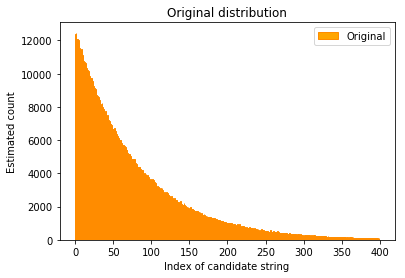

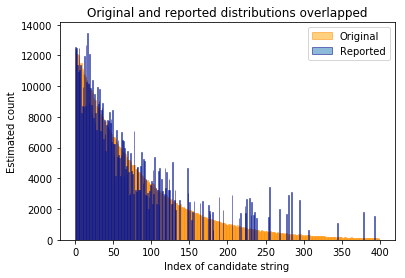

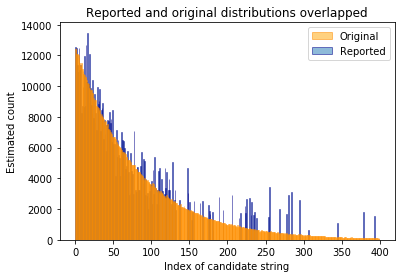

In [72]:
generate_plots(original, estimates, M_total)

## Measuring the quality of decoding

It would be nice to have an automatic way of judging how good the decoding worked.

### Mean absolute error

A simple such measure is the Manhattan distance between the actual and the reported distribution, divided by the number of points.

In [73]:
def absolute_error(actual, reported):
    return np.sum(np.abs(actual - reported)) / len(actual)

In [74]:
absolute_error(original, estimates)

849.26499999999999

An alternative is computing the count of wrong estimates (by how much we overshoot / undershoot) divided by the real counts:

In [75]:
def relative_error(actual, reported):
    return np.sum(np.abs(reported - actual)) / actual.sum()

In [76]:
relative_error(original, estimates)

0.33970600000000001

### Precision and Recall

A more sophisticated way of measuring the quality is in terms of precision and recall.

- Precision: Out of the candidates that the analysis found, how many were actually reported from clients? $\mathit{tp} / (\mathit{tp} + \mathit{fp})$
- Recall: Out of the actually reported candidates, how many are found by the analysis? $\mathit{tp} / (\mathit{tp} + \mathit{fn})$

The problem is that here it's not clear how to calculate tp, tn, fp, fn.

#### Simplified

In the original repo, Google ignores estimates for calculating these metrics. If a reported string is found by the analysis, it's counted as a true positive even if the estimated counts are completely off. The only thing that matters here is whether a string was reported/found or not.

In [77]:
def precision_recall(actual, reported):
    # TODO: Find a better function name or split this into 3 functions
    found = set(np.where(reported != 0)[0])
    sent = set(np.where(actual != 0)[0])

    tp = len(found.intersection(sent))
    fp = len(found - sent)
    fn = len(sent - found)

    precision = tp / float(tp + fp)
    recall = tp / float(tp + fn)
    
    return precision, recall

In [78]:
precision_recall(original, estimates)

(1.0, 0.4075)

#### Fuzzy

It's not clear if we really want to ignore estimates. Here, each reported or actual occurence is counted as one data point.

The true positive count is by how much reported and actual agree. Reported overshooting corresponds to false positives, undershooting corresponds to false negatives.

In [79]:
def fuzzy_precision_recall(actual, reported):
    tp = np.minimum(estimates, original).sum()

    diff = estimates - original
    fp = diff[diff > 0].sum()
    fn = -diff[diff < 0].sum()

    summed = tp + fp + fn

    tp = tp / summed
    fp = fp / summed
    fn = fn / summed

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

In [80]:
fuzzy_precision_recall(original, estimates)

(0.88565060660360384, 0.75818600000000003)

### Bhattacharyya

The [Bhattacharyya distance](https://en.wikipedia.org/wiki/Bhattacharyya_distance) calculates the similarity of two probability distributions.

In [81]:
def bhattacharyya_coefficient(p, q):   
    return np.sqrt(p * q).sum()

def bhattacharyya(actual, reported):
    p = actual / float(actual.sum())
    q = reported / float(reported.sum())
    return -np.log(bhattacharyya_coefficient(p, q))

In [82]:
bhattacharyya(original, estimates)

0.10934522590421167

### Putting it all together

Just a small helper function for looking at all metrics at once.

In [83]:
from IPython.display import Markdown, display

In [84]:
def print_error_metrics(original, estimates):
    abs_error = absolute_error(original, estimates)
    rel_error = relative_error(original, estimates)
    precision, recall = precision_recall(original, estimates)
    fuzzy_precision, fuzzy_recall = fuzzy_precision_recall(original, estimates)
    bha_similarity = bhattacharyya(original, estimates)
    
    display(Markdown("""\
| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| %.3f           | %.3f           | (%.3f, %.3f)      | (%.3f, %.3f)            | %.3f
    """ % (abs_error, rel_error, precision, recall, fuzzy_precision, fuzzy_recall, bha_similarity)))

In [85]:
print_error_metrics(original, estimates)

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 849.265           | 0.340           | (1.000, 0.407)      | (0.886, 0.758)            | 0.109
    

## Finding significant results – Option 2: Based on p-values

To figure out which coefficients are really significant, we perform a two-sided t-test. In other words, we want to find the coefficients where we are confident that the value is unlikely to be just based on noise.

**TODO**: Is a two-sided test really correct here? It's the default for regression analysis but Google mentions a one-sided test in their code (though that part is also commented out). Maybe it has to be one-sided because of the nonnegativity constraint

The null hypothesis is that a coefficient is equal to 0, i.e. it has no effect on the outcome. The standard deviation is computed using covariance matrix because we are working in a multivariate dataset.

In [86]:
from scipy import stats
from numpy.linalg import inv

The significance level is the same as in the paper, 0.05, which is decreased using the Bonferroni correction.

In [87]:
significance_level = 0.05
bonferroni_corrected_level = significance_level / M_total

We use the coefficients that we get by resampling. It's not clear if this should be used here.

**TODO**: Test if resampling helps or not in this case

In [88]:
A, b = normalize(X, y, stds)
coefs = find_coefs(X, y, stds)
params = np.mean(coefs, axis=0)

In [89]:
predictions = A.dot(params)
num_datapoints, num_features = X.shape
MSE = norm(b - predictions, ord=2)**2 / (num_datapoints - num_features)

In [90]:
var = MSE * inv(A.T.dot(A)).diagonal()
sd = np.sqrt(var)
ts = params / sd

We multiply with $2$ because it's a two-sided test and the t-distribution is symmetric.

In [91]:
degrees_of_freedom = num_datapoints - 1
p_values = np.array([2 * (1 - stats.t.cdf(np.abs(i), degrees_of_freedom)) for i in ts])

In [92]:
significant_i = np.where(p_values <= bonferroni_corrected_level)[0]
significant = params[significant_i]

In [93]:
len(significant_i)

79

In [94]:
analyzed = np.zeros(M)
analyzed[significant_i] = significant
estimates = analyzed * N.sum()

Putting it all together into one function:

In [95]:
def get_significant_analysis_estimates(coefs, A, b, M, M_total, N, significance_level=0.05):
    bonferroni_corrected_level = significance_level / M_total    
    params = np.mean(coefs, axis=0)

    predictions = A.dot(params)
    num_datapoints, num_features = X.shape
    MSE = norm(b - predictions, ord=2)**2 / (num_datapoints - num_features)
    
    var = MSE * inv(A.T.dot(A)).diagonal()
    sd = np.sqrt(var)
    ts = params / sd
    
    degrees_of_freedom = num_datapoints - 1
    p_values = np.array([2 * (1 - stats.t.cdf(np.abs(i), degrees_of_freedom)) for i in ts])
    
    significant_i = np.where(p_values <= bonferroni_corrected_level)[0]
    significant = params[significant_i]
    
    analyzed = np.zeros(M)
    analyzed[significant_i] = significant
    estimates = analyzed * N.sum()
    
    return estimates, significant_i

In [96]:
estimates2, significant_i2 = get_significant_analysis_estimates(coefs, A, b, M, M_total, N)

In [97]:
assert(all(estimates == estimates2))
assert(all(significant_i == significant_i2))

In [98]:
if use_lasso:
    estimates = undo_filtering(estimates, good_candidates, M_total)

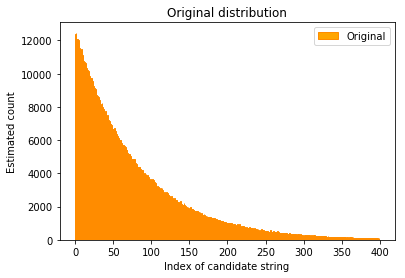

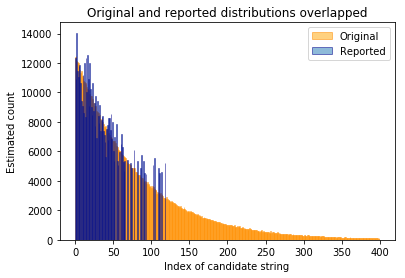

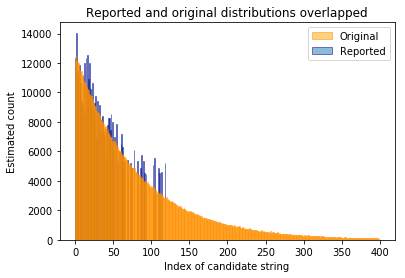

In [99]:
generate_plots(original, estimates, M_total)

---

## Using different distributions

This function is pretty huge, but it basically performs the entire analysis with different options:

In [100]:
def run_analysis(distribution, use_superset=True, use_lasso=False, use_p_value_tests=False):
    PARAMS_PATH, COUNTS_PATH, MAP_PATH, CANDIDATES_PATH, TRUE_VALUES_PATH = get_paths(data_folder, distribution)

    k, h, m, p, q, f = load_params(PARAMS_PATH)
    counts = load_counts(COUNTS_PATH)
    N, c = destructure_counts(counts)
    maps = load_map(MAP_PATH)
    
    if use_superset:
        candidates = ["v%d" % i for i in range(1, superset_size)]
    else:
        candidates = get_candidates()
    
    M = len(candidates)
    M_total = M
    candidates_total = candidates

    y = get_target_values(c, N)
    X = get_features(candidates)
    stds = calculate_variances(counts).reshape((k * m))
    
    if use_lasso:
        X, candidates, M, good_candidates = filter_candidates(X, y, candidates)
    
    coefs = find_coefs(X, y, stds)
    
    if use_p_value_tests:
        A, b = normalize(X, y, stds)
        estimates, reported_candidates = get_significant_analysis_estimates(coefs, A, b, M, M_total, N)
    else:
        estimates, reported_candidates = get_analysis_estimates(coefs, N, M, cut_off_factor=2)
    
    if use_lasso:
        estimates = undo_filtering(estimates, good_candidates, M_total)

    #print create_estimate_df(candidates_total, estimates).head(15)

    original = load_original_data(TRUE_VALUES_PATH, M_total)
    generate_plots(original, estimates, M_total)
    print_error_metrics(original, estimates)

To see how well the analysis works, it's useful to test with different distributions. Additionally, we also optionally use Lasso. Observe that the results with Lasso generally contain no false positives at all (e.g. they have a perfect precision), but the estimated counts are not as good. This means that the error measures usually report worse results here.

In [101]:
def run_tests():
    display(Markdown("### p-value significance test, without Lasso"))

    for distribution in distributions:
        display(Markdown("### %s" % distribution))

        display(Markdown("#### Without superset"))
        run_analysis(distribution, use_superset=False, use_p_value_tests=True)

        display(Markdown("#### With superset"))
        run_analysis(distribution, use_superset=True, use_p_value_tests=True)
            
    display(Markdown("### Resampling consistency test, without Lasso"))

    for distribution in distributions:
        display(Markdown("### %s" % distribution))

        display(Markdown("#### Without superset"))
        run_analysis(distribution, use_superset=False)

        display(Markdown("#### With superset"))
        run_analysis(distribution, use_superset=True)
        
    display(Markdown("### p-value significance test, with Lasso"))

    for distribution in distributions:
        display(Markdown("### %s" % distribution))

        display(Markdown("#### Without superset"))
        run_analysis(distribution, use_superset=False, use_p_value_tests=True, use_lasso=True)

        display(Markdown("#### With superset"))
        run_analysis(distribution, use_superset=True, use_p_value_tests=True, use_lasso=True)

    display(Markdown("### Resampling consistency test, with Lasso"))

    for distribution in distributions:
        display(Markdown("### %s" % distribution))

        display(Markdown("#### Without superset"))
        run_analysis(distribution, use_superset=False, use_lasso=True)

        display(Markdown("#### With superset"))
        run_analysis(distribution, use_superset=True, use_lasso=True)

### p-value significance test, without Lasso

### gauss

#### Without superset

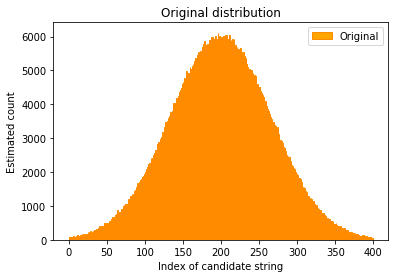

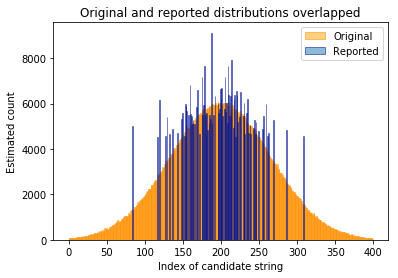

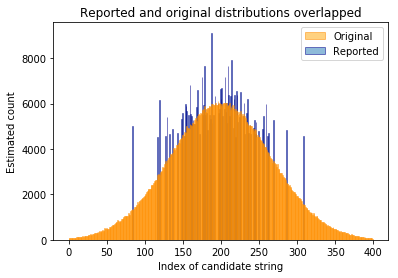

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 1571.159           | 0.628           | (1.000, 0.217)      | (0.930, 0.580)            | 0.411
    

#### With superset

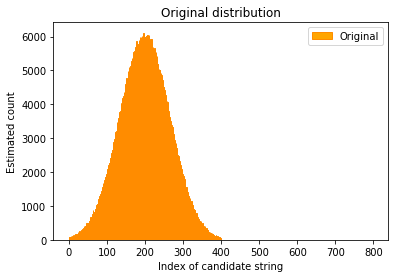

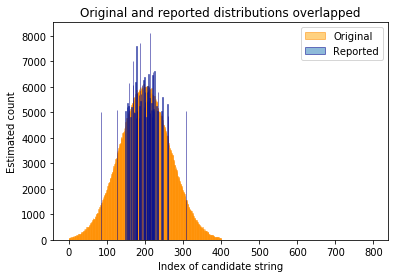

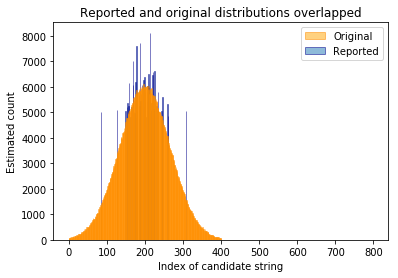

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 902.736           | 0.721           | (1.000, 0.150)      | (0.930, 0.580)            | 0.570
    

### zipf1

#### Without superset

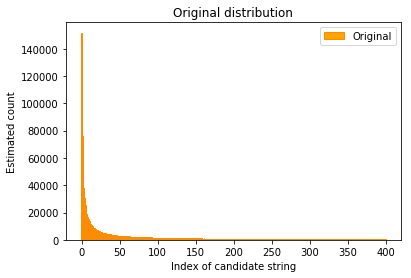

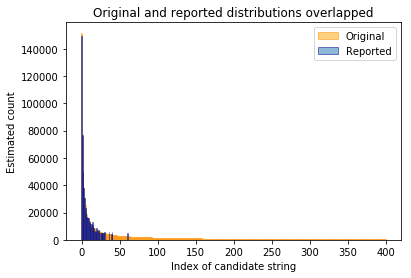

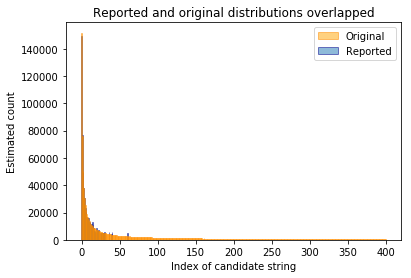

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 1046.697           | 0.419           | (1.000, 0.085)      | (0.930, 0.580)            | 0.240
    

#### With superset

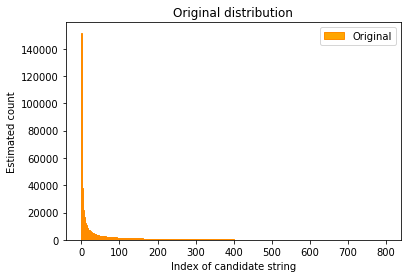

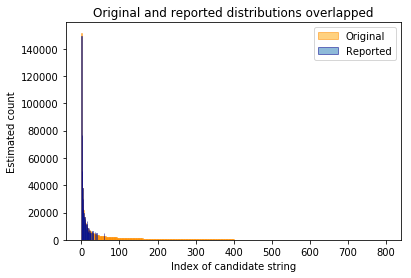

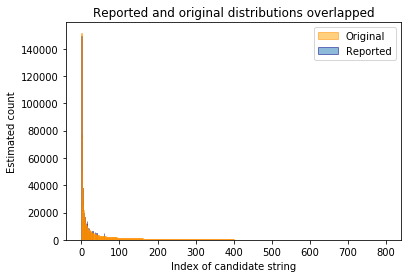

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 543.713           | 0.434           | (1.000, 0.077)      | (0.930, 0.580)            | 0.252
    

### zipf1.5

#### Without superset

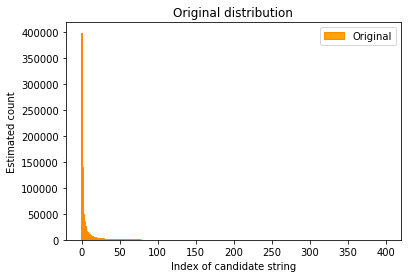

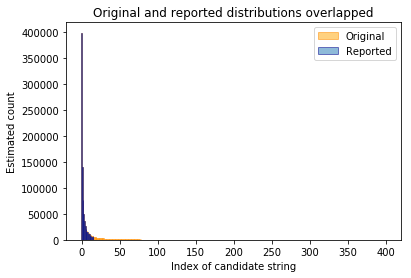

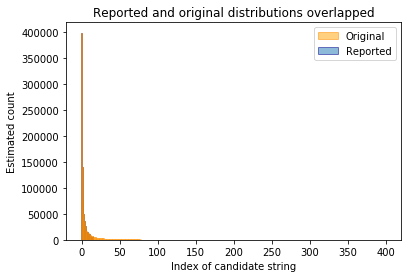

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 427.424           | 0.171           | (1.000, 0.040)      | (0.930, 0.580)            | 0.085
    

#### With superset

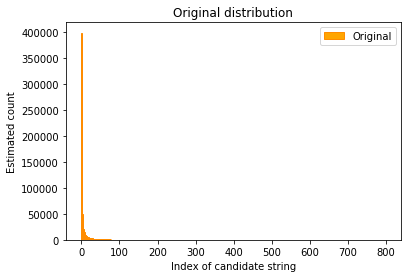

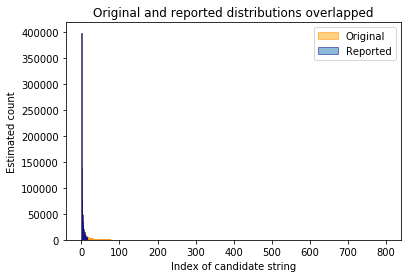

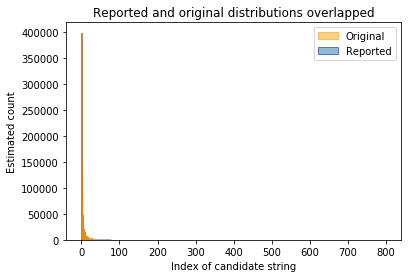

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 219.727           | 0.176           | (1.000, 0.040)      | (0.930, 0.580)            | 0.085
    

### exp

#### Without superset

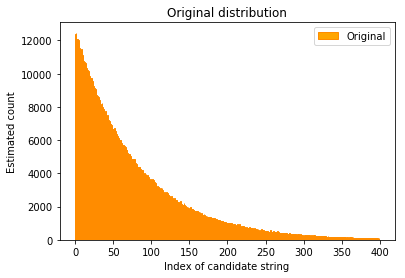

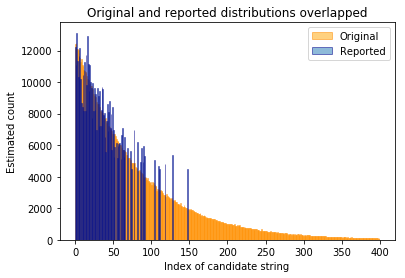

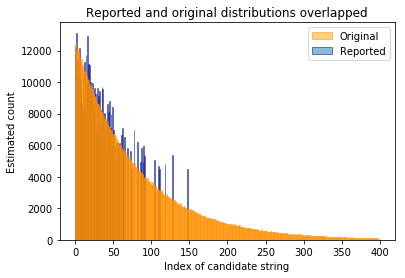

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 1173.066           | 0.469           | (1.000, 0.200)      | (0.930, 0.580)            | 0.247
    

#### With superset

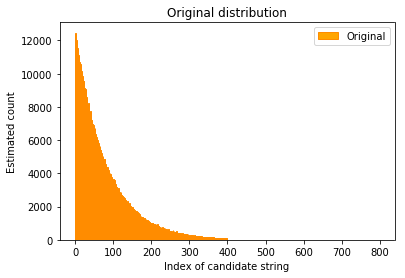

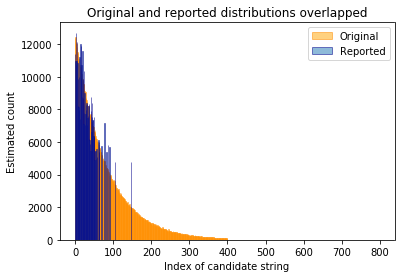

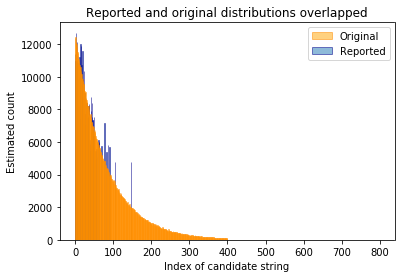

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 647.068           | 0.517           | (1.000, 0.168)      | (0.930, 0.580)            | 0.296
    

### unif

#### Without superset

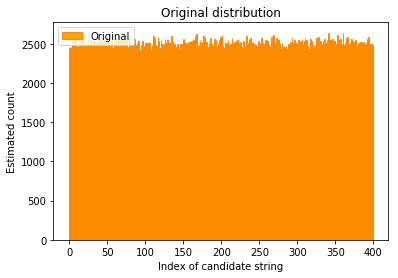

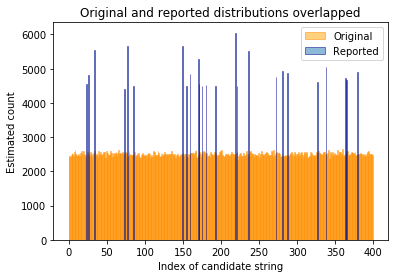

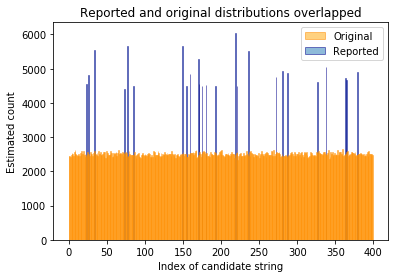

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 2494.967           | 0.998           | (1.000, 0.062)      | (0.930, 0.580)            | 1.389
    

#### With superset

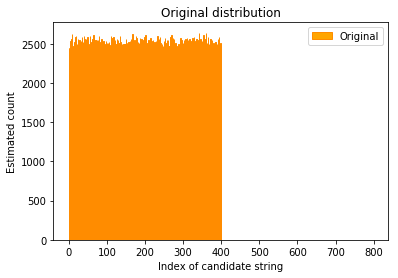

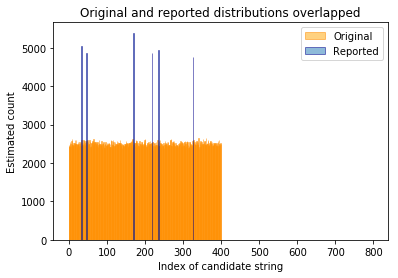

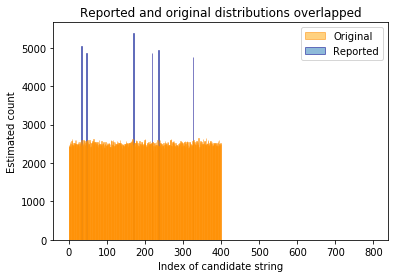

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 1251.203           | 1.000           | (1.000, 0.015)      | (0.930, 0.580)            | 2.097
    

### Resampling consistency test, without Lasso

### gauss

#### Without superset

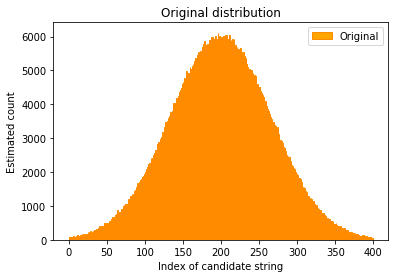

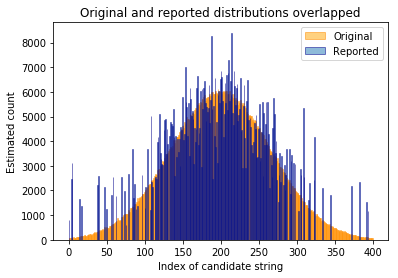

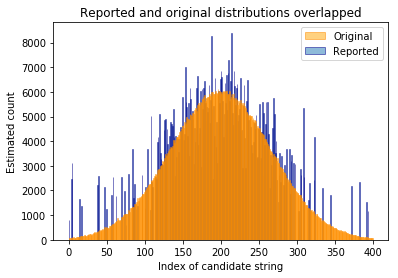

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 931.503           | 0.373           | (1.000, 0.530)      | (0.930, 0.580)            | 0.113
    

#### With superset

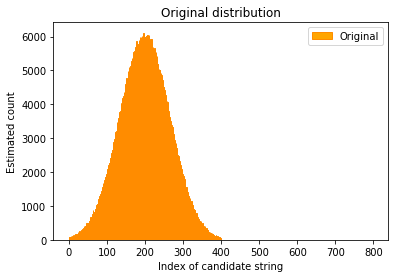

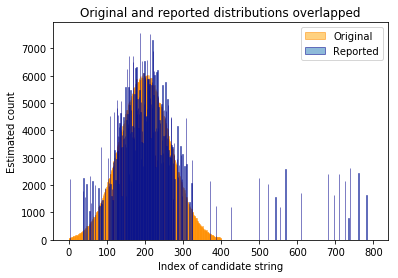

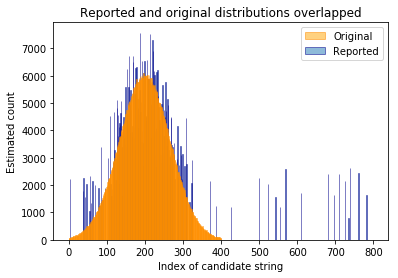

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 530.733           | 0.424           | (0.927, 0.477)      | (0.930, 0.580)            | 0.152
    

### zipf1

#### Without superset

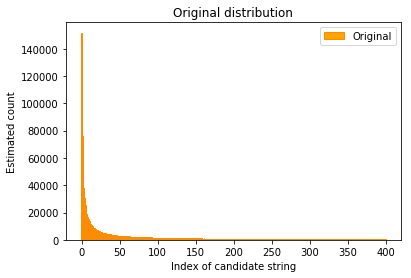

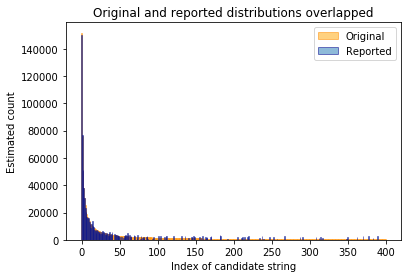

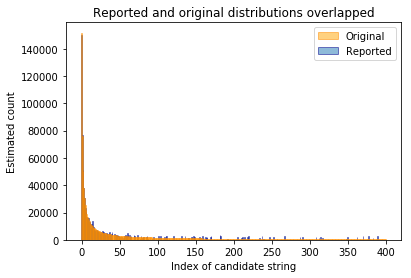

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 900.442           | 0.360           | (1.000, 0.307)      | (0.930, 0.580)            | 0.144
    

#### With superset

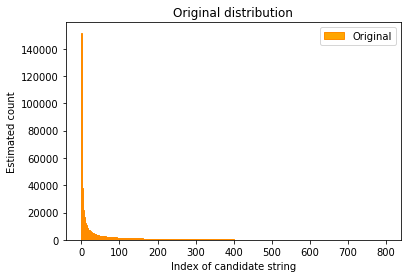

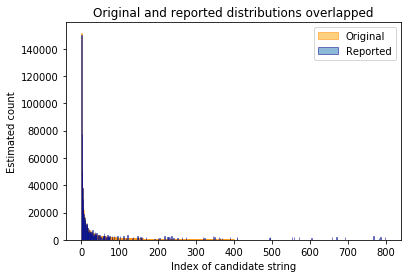

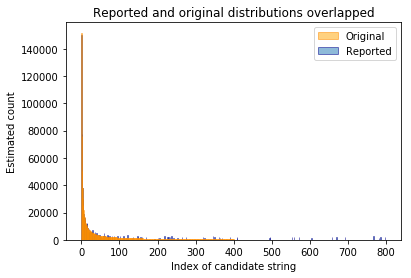

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 488.089           | 0.390           | (0.866, 0.242)      | (0.930, 0.580)            | 0.180
    

### zipf1.5

#### Without superset

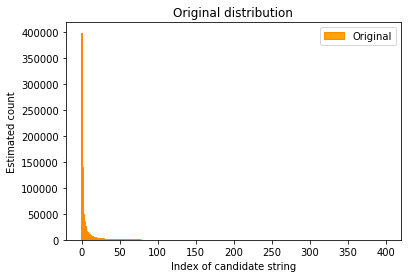

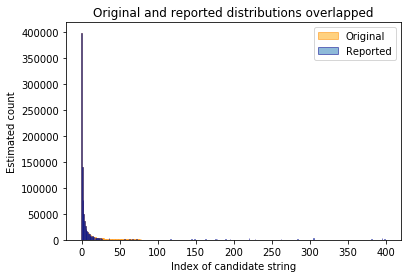

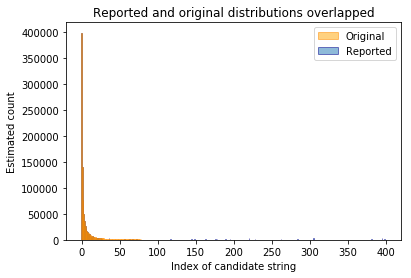

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 402.363           | 0.161           | (1.000, 0.117)      | (0.930, 0.580)            | 0.068
    

#### With superset

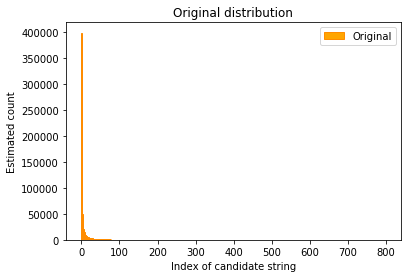

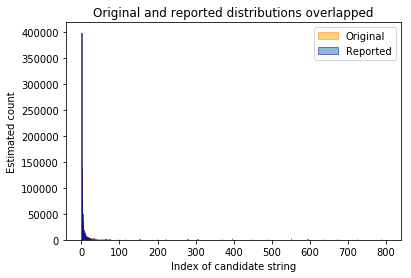

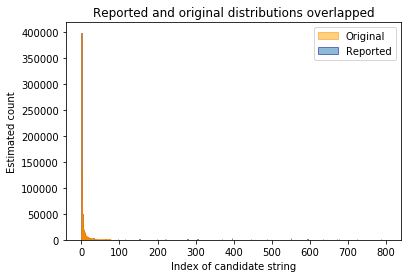

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 210.283           | 0.168           | (0.824, 0.105)      | (0.930, 0.580)            | 0.069
    

### exp

#### Without superset

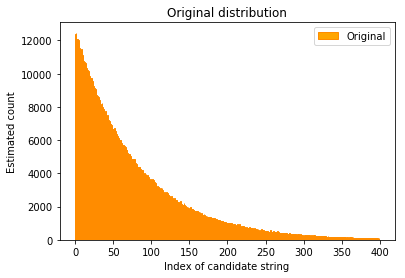

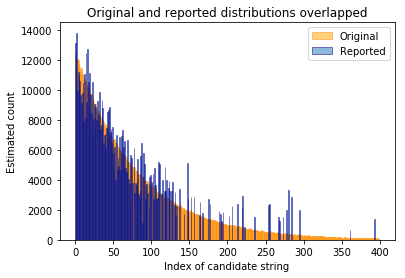

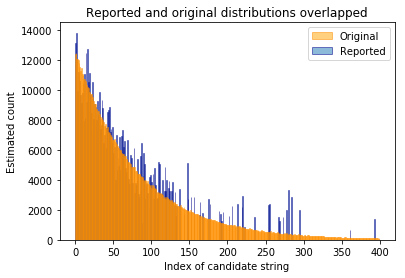

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 880.200           | 0.352           | (1.000, 0.388)      | (0.930, 0.580)            | 0.115
    

#### With superset

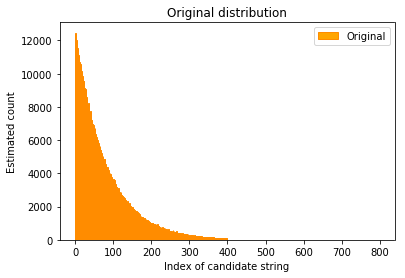

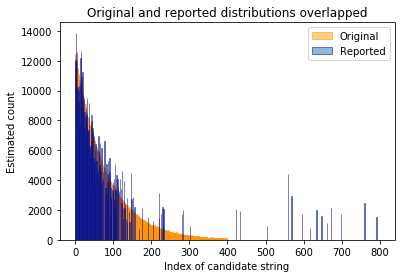

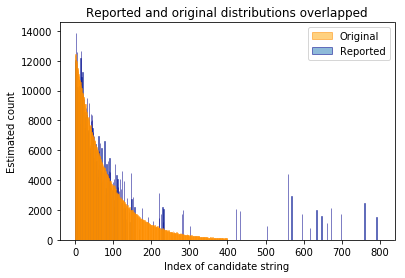

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 485.293           | 0.388           | (0.907, 0.340)      | (0.930, 0.580)            | 0.151
    

### unif

#### Without superset

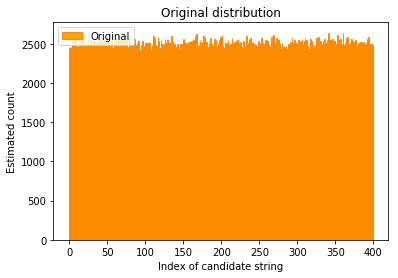

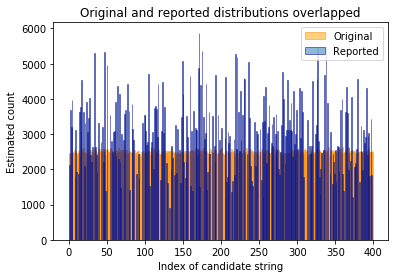

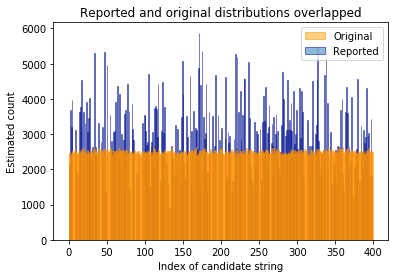

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 1401.475           | 0.561           | (1.000, 0.672)      | (0.930, 0.580)            | 0.211
    

#### With superset

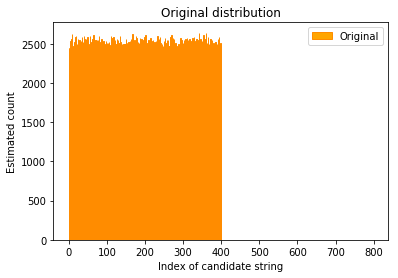

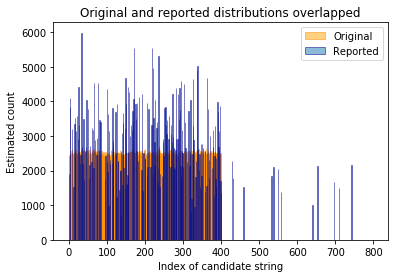

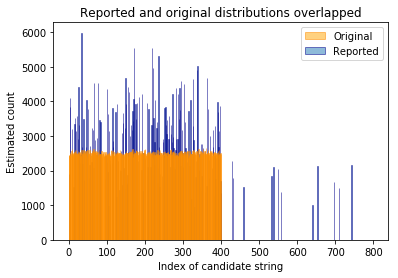

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 841.607           | 0.672           | (0.946, 0.522)      | (0.930, 0.580)            | 0.357
    

### p-value significance test, with Lasso

### gauss

#### Without superset

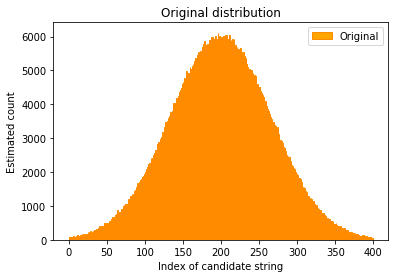

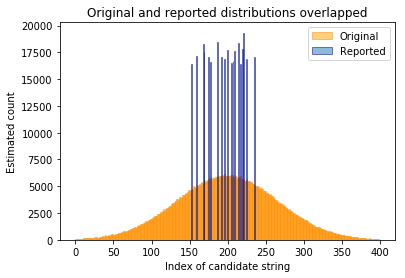

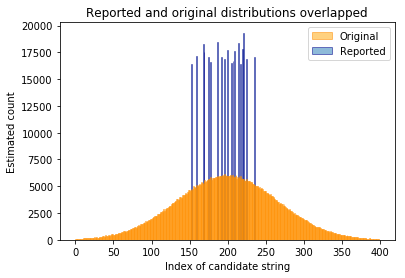

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 2786.702           | 1.115           | (1.000, 0.048)      | (0.930, 0.580)            | 1.115
    

#### With superset

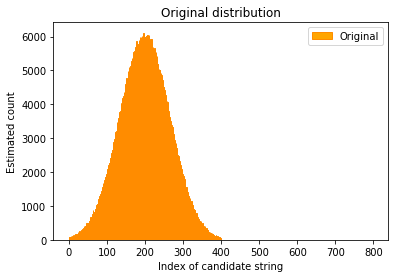

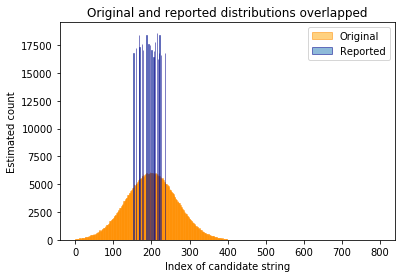

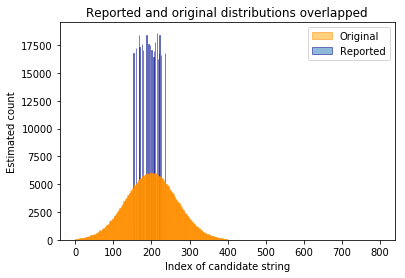

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 1394.432           | 1.114           | (1.000, 0.048)      | (0.930, 0.580)            | 1.115
    

### zipf1

#### Without superset

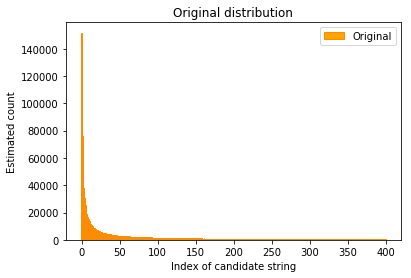

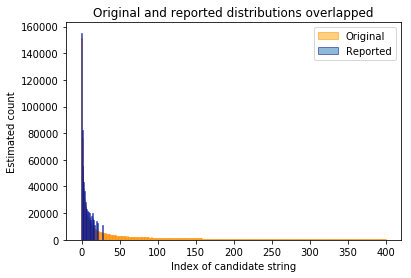

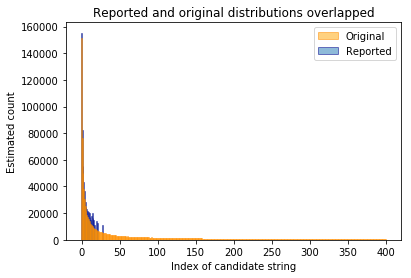

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 1394.833           | 0.558           | (1.000, 0.052)      | (0.930, 0.580)            | 0.302
    

#### With superset

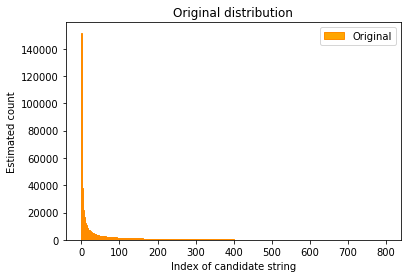

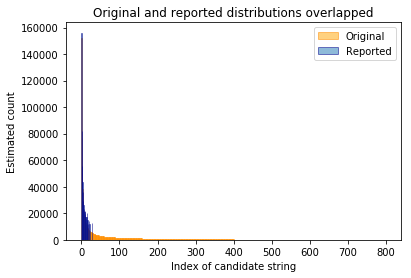

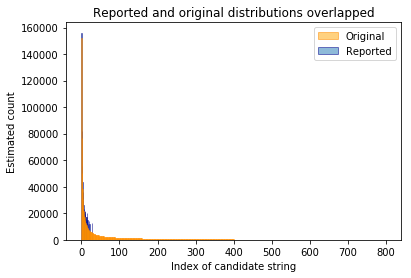

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 702.097           | 0.561           | (1.000, 0.052)      | (0.930, 0.580)            | 0.302
    

### zipf1.5

#### Without superset

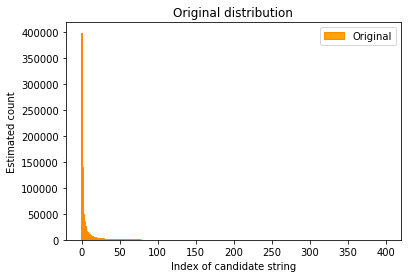

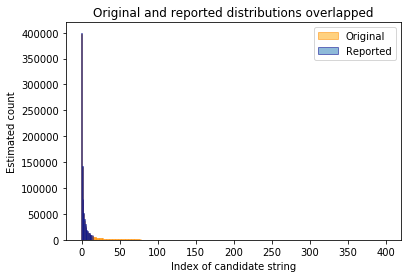

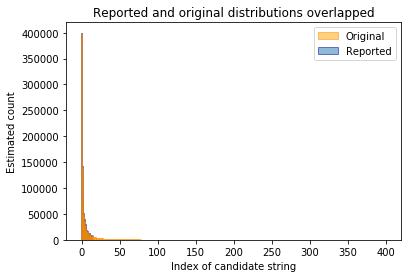

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 479.722           | 0.192           | (1.000, 0.037)      | (0.930, 0.580)            | 0.089
    

#### With superset

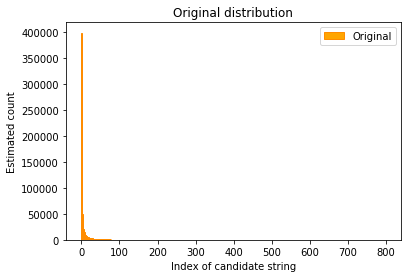

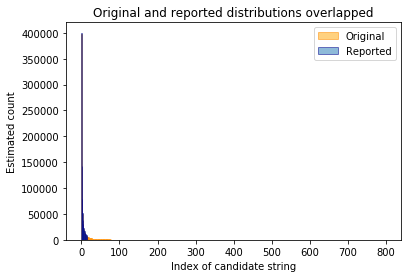

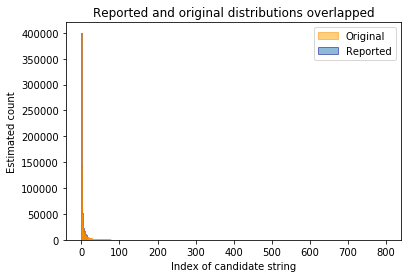

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 243.190           | 0.194           | (1.000, 0.037)      | (0.930, 0.580)            | 0.089
    

### exp

#### Without superset

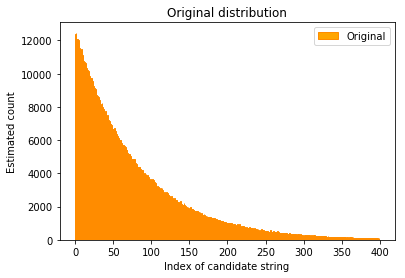

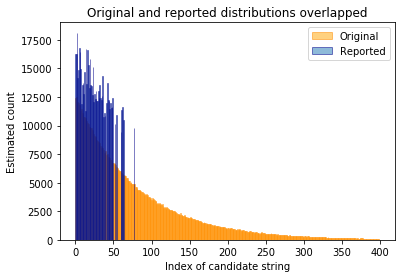

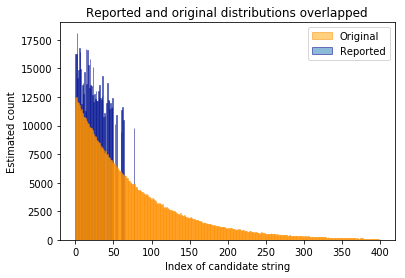

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 1825.047           | 0.730           | (1.000, 0.140)      | (0.930, 0.580)            | 0.348
    

#### With superset

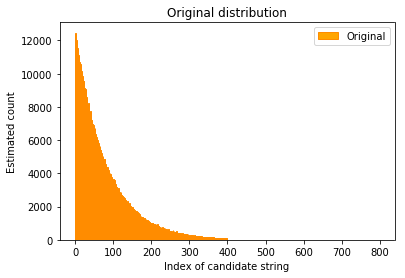

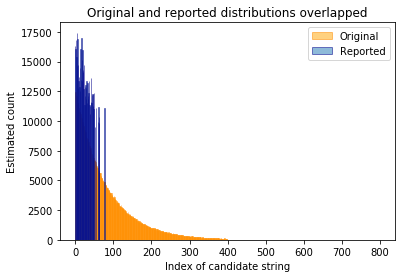

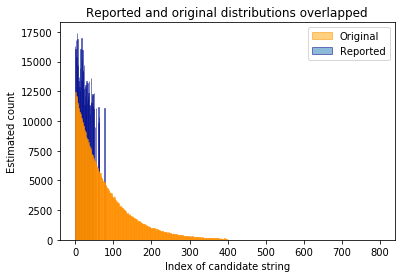

| Absolute error | Relative error | Precision, recall | Fuzzy precision, recall | Bhattacharyya
| -------------- |----------------| ------------------| ----------------------- | -------------
| 911.348           | 0.728           | (1.000, 0.140)      | (0.930, 0.580)            | 0.348
    

### unif

#### Without superset

ValueError: failed to create intent(cache|hide)|optional array-- must have defined dimensions but got (0,)

In [102]:
run_tests()

---

# Experiments

The notebook content so far described an entire RAPPOR analysis. The content from now on focuses on different experiments to improve accuracy/performance or to better understand why some results hold.

## Only using one linear regression

This is an experiment where we only use one Lasso regression, instead of two chained linear regressions. Generally, this performs worse because the estimates are off. It seems like the regularization prevents the coefficients from growing to the values that they should actually have.

If $\alpha$ is tuned well, it performs alright, but it's not clear if that's just coincidence.

In [ ]:
from sklearn.linear_model import Lasso

def fit(X, y, stds, alpha=0.00001):
    A, b = normalize(X, y, stds)
    clf = Lasso(positive=True, fit_intercept=False, alpha=alpha)
    clf.fit(A, b)
    
    coefs = clf.coef_
    summed = coefs.sum()
    
    if summed > 1:
        coefs = coefs / summed
        
    return coefs

In [ ]:
run_tests()

### Experiment: Not using normalization

In [ ]:
from scipy.optimize import nnls

In [ ]:
estimates = nnls(X, y)[0] * N.sum()